In [373]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import io
import seaborn as sns; sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Procuring Data
First we need to extract the tickers for SnP-500

In [14]:
# The first input contains the list of tickers
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Disable SSL verification warnings for Wikipedia
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

# Fetch the content without verifying the SSL certificate
response = requests.get(url, verify=False)

# Read the content as a CSV file with pandas
ticker_df = pd.read_html(io.StringIO(response.text))[0]
ticker_df

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


#### We will rely on Yahoo Finance API for our data
However YFinance is not always a reliable data measure since
* Unofficial / not necessarily maintained
* Can get you rate limited/blacklisted

Lets verify if the intraday stock data is correctly downloading

In [15]:
data = yf.download(tickers=['MMM', 'ACN'], start="2022-01-01", end="2022-12-31", interval='60m')
data

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close              \
                                  ACN         MMM         ACN         MMM   
Datetime                                                                    
2022-01-03 09:30:00-05:00  408.825012  177.214996  408.825012  177.214996   
2022-01-03 10:30:00-05:00  407.040009  176.820007  407.040009  176.820007   
2022-01-03 11:30:00-05:00  407.329987  176.529999  407.329987  176.529999   
2022-01-03 12:30:00-05:00  406.739990  176.440002  406.739990  176.440002   
2022-01-03 13:30:00-05:00  407.864990  177.089996  407.864990  177.089996   
...                               ...         ...         ...         ...   
2022-12-30 11:30:00-05:00  265.130005  119.730003  265.130005  119.730003   
2022-12-30 12:30:00-05:00  263.890015  118.930000  263.890015  118.930000   
2022-12-30 13:30:00-05:00  263.489990  118.820000  263.489990  118.820000   
2022-12-30 14:30:00-05:00  265.000092  119.195503  265.000092  119.195503   
2022-12-30 15:30:00-05:00  266.809998  119.919998  266.809998  119.919998   

                                 High                     Low              \
                                  ACN         MMM         ACN         MMM   
Datetime                                                                    
2022-01-03 09:30:00-05:00  415.529999  179.089996  406.140015  176.429993   
2022-01-03 10:30:00-05:00  410.109985  177.199997  406.170013  176.244995   
2022-01-03 11:30:00-05:00  408.287292  176.785004  405.040009  176.139999   
2022-01-03 12:30:00-05:00  407.434998  176.580002  405.910004  175.839996   
2022-01-03 13:30:00-05:00  408.269989  177.259995  406.130005  176.220001   
...                               ...         ...         ...         ...   
2022-12-30 11:30:00-05:00  265.760010  119.769897  264.140015  119.199997   
2022-12-30 12:30:00-05:00  265.399994  119.739998  263.250000  118.730003   
2022-12-30 13:30:00-05:00  264.390015  119.160004  262.600006  118.720001   
2022-12-30 14:30:00-05:00  265.649994  119.300003  263.160004  118.510002   
2022-12-30 15:30:00-05:00  266.890015  120.029999  264.920013  119.169998   

                                 Open              Volume          
                                  ACN         MMM     ACN     MMM  
Datetime                                                           
2022-01-03 09:30:00-05:00  414.660004  178.320007  393749  384623  
2022-01-03 10:30:00-05:00  408.855011  177.179993  349389  158291  
2022-01-03 11:30:00-05:00  406.970001  176.759995  164645  125963  
2022-01-03 12:30:00-05:00  407.329987  176.570007  126556  123903  
2022-01-03 13:30:00-05:00  406.618713  176.449997  101643  116232  
...                               ...         ...     ...     ...  
2022-12-30 11:30:00-05:00  264.361908  119.290001   93806  167151  
2022-12-30 12:30:00-05:00  265.109985  119.739998  130398  209910  
2022-12-30 13:30:00-05:00  263.820007  118.930000  130610  163912  
2022-12-30 14:30:00-05:00  263.500000  118.794998  157574  230316  
2022-12-30 15:30:00-05:00  264.989990  119.209999  199839  422759  

[1754 rows x 12 columns]

Seems like API is working fine. Although please note that there can be timezone differences in datetime column so we might need to adjust times accordingly for real time trading.

# !! Time to download all the data !! 
The data is intraday hourly for the entire year of 2022

In [16]:
data = yf.download(tickers=ticker_df["Symbol"].tolist(), interval='60m', start="2022-01-01", end="2022-12-31")
data

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- GEHC: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


Adj Close                                   \
                                    A      AAL         AAP        AAPL   
2022-01-03 09:30:00-05:00  155.263000  19.1000  239.389999  180.839996   
2022-01-03 10:30:00-05:00  155.110901  18.8750  235.559998  181.749893   
2022-01-03 11:30:00-05:00  155.320007  18.7750  235.729996  181.600006   
2022-01-03 12:30:00-05:00  155.350006  18.7950  234.994995  182.229706   
2022-01-03 13:30:00-05:00  156.244995  18.7600  236.630005  181.865005   
...                               ...      ...         ...         ...   
2022-12-30 11:30:00-05:00  148.660004  12.6950  146.854996  128.815002   
2022-12-30 12:30:00-05:00  148.100006  12.6150  146.990005  128.330002   
2022-12-30 13:30:00-05:00  148.315002  12.5950  146.755005  128.220001   
2022-12-30 14:30:00-05:00  149.029999  12.6476  146.729996  128.910004   
2022-12-30 15:30:00-05:00  149.639999  12.7300  147.039993  129.949997   

                                                                          \
                                 ABBV         ABC         ABT       ACGL   
2022-01-03 09:30:00-05:00  134.789993  131.994995  138.315002  44.630001   
2022-01-03 10:30:00-05:00  133.929993  131.699997  137.835007  44.200001   
2022-01-03 11:30:00-05:00  134.210007  132.160004  138.445007  44.180000   
2022-01-03 12:30:00-05:00  134.250000  132.220001  138.072693  44.279999   
2022-01-03 13:30:00-05:00  134.675003  132.100006  138.490005  44.209999   
...                               ...         ...         ...        ...   
2022-12-30 11:30:00-05:00  160.660004  164.755005  109.074997  62.660000   
2022-12-30 12:30:00-05:00  160.292496  164.630005  108.919998  62.529999   
2022-12-30 13:30:00-05:00  160.580002  164.619995  108.959999  62.654400   
2022-12-30 14:30:00-05:00  161.070007  164.830002  109.510002  62.500000   
2022-12-30 15:30:00-05:00  161.639999  165.720001  109.830002  62.770000   

                                                   ...    Volume            \
                                  ACN        ADBE  ...      WYNN       XEL   
2022-01-03 09:30:00-05:00  408.825012  560.840027  ...  684955.0  710031.0   
2022-01-03 10:30:00-05:00  407.040009  561.349976  ...  400553.0  428498.0   
2022-01-03 11:30:00-05:00  407.329987  560.590027  ...  218204.0  237985.0   
2022-01-03 12:30:00-05:00  406.739990  561.320007  ...  171908.0  228360.0   
2022-01-03 13:30:00-05:00  407.864990  560.840027  ...  265534.0  226801.0   
...                               ...         ...  ...       ...       ...   
2022-12-30 11:30:00-05:00  265.130005  333.500000  ...  144026.0   95959.0   
2022-12-30 12:30:00-05:00  263.890015  332.170013  ...  138020.0   96441.0   
2022-12-30 13:30:00-05:00  263.489990  332.609985  ...  105578.0  113486.0   
2022-12-30 14:30:00-05:00  265.000092  334.250000  ...  219021.0  232857.0   
2022-12-30 15:30:00-05:00  266.809998  336.519989  ...  419257.0  358204.0   

                                                                              \
                                 XOM      XRAY       XYL       YUM       ZBH   
2022-01-03 09:30:00-05:00  5522529.0  100870.0   93697.0  200080.0       0.0   
2022-01-03 10:30:00-05:00  3189626.0  132951.0   88095.0  203934.0  174706.0   
2022-01-03 11:30:00-05:00  2365012.0  210678.0   52773.0   95346.0   76705.0   
2022-01-03 12:30:00-05:00  1785623.0  154594.0   37721.0   75781.0  100002.0   
2022-01-03 13:30:00-05:00  2334192.0  109545.0   53480.0   53928.0   98571.0   
...                              ...       ...       ...       ...       ...   
2022-12-30 11:30:00-05:00   942041.0   91553.0   40147.0   62365.0   90650.0   
2022-12-30 12:30:00-05:00   990811.0   67262.0   39511.0   73270.0   90217.0   
2022-12-30 13:30:00-05:00   863000.0  102686.0   46114.0   78855.0   44031.0   
2022-12-30 14:30:00-05:00  1285210.0  192132.0   46778.0  121536.0  164053.0   
2022-12-30 15:30:00-05:00  2301442.0  356990.0  111695.0  433648.0   97439.0   

                    

In [17]:
# Store each stock's data in a separate DataFrame
stock_data = {}
unavailable = ["BRK.B", "BF.B", "GEHC"]
tickers = ticker_df["Symbol"].tolist()
tickers = [x for x in tickers if x not in unavailable] 
for ticker in tickers:
    stock_data[ticker] = data.xs(ticker, level=1, axis=1)
stock_data["MMM"]

,Adj Close,Close,High,Low,Open,Volume
2022-01-03 09:30:00-05:00,177.214996,177.214996,179.089996,176.429993,178.320007,384623.0
2022-01-03 10:30:00-05:00,176.820007,176.820007,177.199997,176.244995,177.179993,158291.0
2022-01-03 11:30:00-05:00,176.529999,176.529999,176.785004,176.139999,176.759995,125963.0
2022-01-03 12:30:00-05:00,176.440002,176.440002,176.580002,175.839996,176.570007,123903.0
2022-01-03 13:30:00-05:00,177.089996,177.089996,177.259995,176.220001,176.449997,116232.0
...,...,...,...,...,...,...
2022-12-30 11:30:00-05:00,119.730003,119.730003,119.769897,119.199997,119.290001,167151.0
2022-12-30 12:30:00-05:00,118.930000,118.930000,119.739998,118.730003,119.739998,209910.0
2022-12-30 13:30:00-05:00,118.820000,118.820000,119.160004,118.720001,118.930000,163912.0
2022-12-30 14:30:00-05:00,119.195503,119.195503,119.300003,118.510002,118.794998,230316.0


# Lets find annualized intraday volatility of each stock

In [19]:
for ticker, df in stock_data.items():
    temp_df = df.copy().dropna()
    
    # calculate daily volatility
    temp_df["Returns"] = temp_df["Adj Close"]/temp_df["Adj Close"].shift(1)
    daily_volatility = temp_df['Returns'].groupby(pd.Grouper(freq='D')).std()

    # Convert the annualized_intraday_volatility series to a DataFrame
    daily_volatility_df = daily_volatility.to_frame(name='Daily Vol')

    # Perform an asof merge with left_index=True and right_index=True
    temp_df = pd.merge_asof(temp_df, daily_volatility_df, left_index=True, right_index=True, direction='forward')
    temp_df.fillna(method='ffill', inplace=True) # forward fill
    
    stock_data[ticker] = temp_df

### For our trading model, we will chose the top 50 stocks with most intraday volatility

In [20]:
# Averaging intraday volatilites for all stocks
mean_vol = {ticker: df["Daily Vol"].mean() for ticker, df in stock_data.items()}

# Reverse sorting based on volatilities
mean_vol = sorted(mean_vol.items(), key=lambda x: x[1], reverse=True)
column_names = ['Ticker', 'Daily Vol']
trade_deck = pd.DataFrame(data=mean_vol[:50], columns=column_names)
trade_deck[:5]

,Ticker,Daily Vol
0,ETSY,0.015262
1,CCL,0.015135
2,ENPH,0.015000
3,NCLH,0.014827
4,MRNA,0.014466


### We also need SnP 500 weights for these stocks. Since this data is not available on any free API I will be using the crsp database provided by my university to calculate approximate daily weights for each of the top 50 volatile stock in SPX using market cap weighting

In [21]:
df_snp = pd.read_csv("snp500_2022.csv")
df_snp["MARKETCAP"] = df_snp["PRC"] * df_snp["VOL"]
df_snp

,PERMNO,date,TICKER,PRC,VOL,SHROUT,OPENPRC,MARKETCAP
0,13210,2022-01-03,EPAM,642.20001,433216,56720,670.32001,2.782113e+08
1,13210,2022-01-04,EPAM,618.71002,509128,56720,641.21002,3.150026e+08
2,13210,2022-01-05,EPAM,587.79999,581163,56720,605.84998,3.416076e+08
3,13210,2022-01-06,EPAM,579.04999,616214,56720,579.45001,3.568187e+08
4,13210,2022-01-07,EPAM,556.67999,471129,56720,578.92999,2.622681e+08
...,...,...,...,...,...,...,...,...
12728,93436,2022-12-23,TSLA,123.15000,166917212,3157752,126.37000,2.055585e+10
12729,93436,2022-12-27,TSLA,109.10000,208446557,3157752,117.49500,2.274152e+10
12730,93436,2022-12-28,TSLA,112.71000,220818648,3157752,110.35000,2.488847e+10
12731,93436,2022-12-29,TSLA,121.82000,221592714,3157752,120.38500,2.699442e+10


In [22]:
# group by date and find individual wts approximate by individual MARKETCAP/ total MARKETCAP
group = df_snp.groupby("date")
df_snp["SNPWT"] = group["MARKETCAP"].transform(lambda x: x/x.sum())
df_snp

,PERMNO,date,TICKER,PRC,VOL,SHROUT,OPENPRC,MARKETCAP,SNPWT
0,13210,2022-01-03,EPAM,642.20001,433216,56720,670.32001,2.782113e+08,0.003072
1,13210,2022-01-04,EPAM,618.71002,509128,56720,641.21002,3.150026e+08,0.003188
2,13210,2022-01-05,EPAM,587.79999,581163,56720,605.84998,3.416076e+08,0.004021
3,13210,2022-01-06,EPAM,579.04999,616214,56720,579.45001,3.568187e+08,0.004021
4,13210,2022-01-07,EPAM,556.67999,471129,56720,578.92999,2.622681e+08,0.003474
...,...,...,...,...,...,...,...,...,...
12728,93436,2022-12-23,TSLA,123.15000,166917212,3157752,126.37000,2.055585e+10,0.470628
12729,93436,2022-12-27,TSLA,109.10000,208446557,3157752,117.49500,2.274152e+10,0.467241
12730,93436,2022-12-28,TSLA,112.71000,220818648,3157752,110.35000,2.488847e+10,0.516440
12731,93436,2022-12-29,TSLA,121.82000,221592714,3157752,120.38500,2.699442e+10,0.515800


# Pattern Analysis

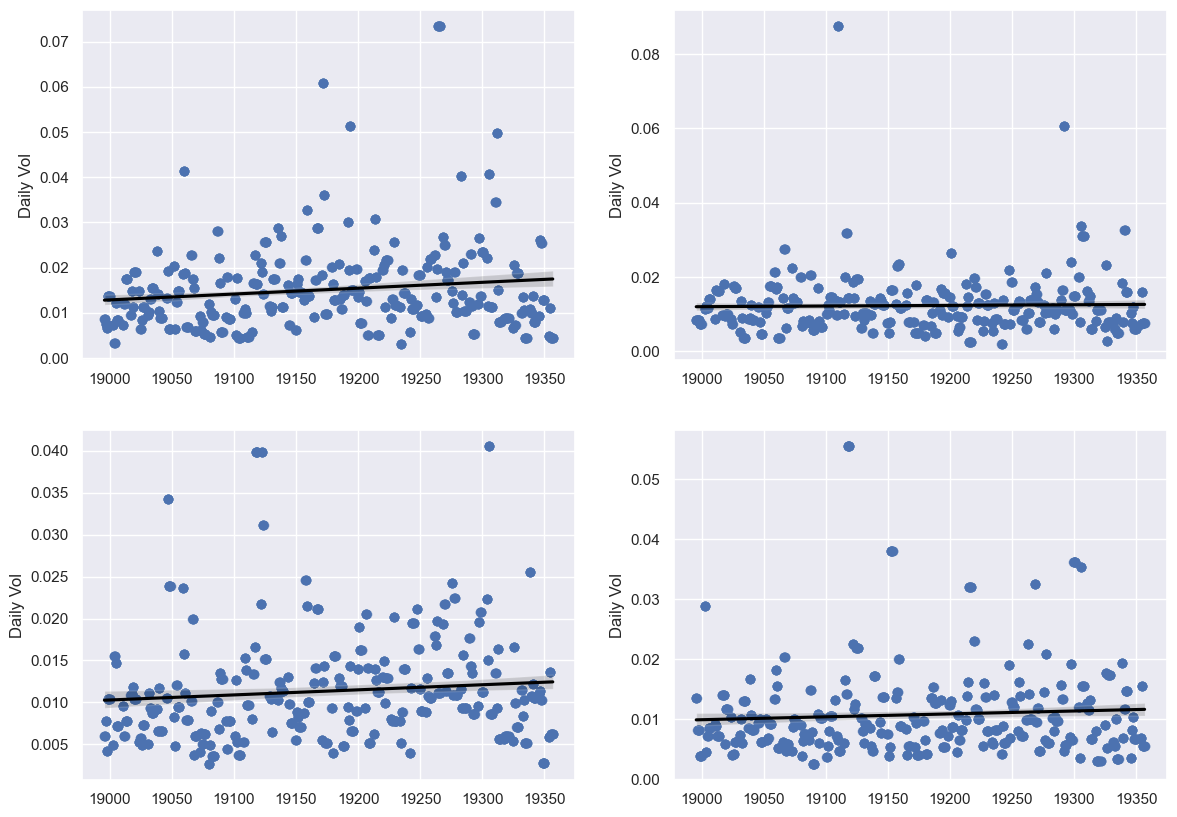

In [23]:
# Lets look at some plots to analyze what kind of data does the volatilities exhibit
# Get 5 tickers -> lets take 1, 10, 20, 30 tickers 
ats = [trade_deck.iloc[i]["Ticker"] for i in [1,18,32,45]]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
row, col = 0,0
for ticker in ats:
    if ticker in stock_data:
        group = stock_data[ticker]
        x_values = mdates.date2num(group.index)
        scatter_kws = {'alpha':0.6}  # set marker color
        line_kws = {'color': "black"}
        sns.regplot(ax=axes[row, col], data=group, x=x_values, y='Daily Vol', scatter_kws=scatter_kws, line_kws=line_kws, ci=100)
        col = col+1
        if col == 2:
            row = row+1
            col=0

Most of the data points are scattered with heavy noise and also have a number of outliers.

### Volatility Partial Autocorrelations

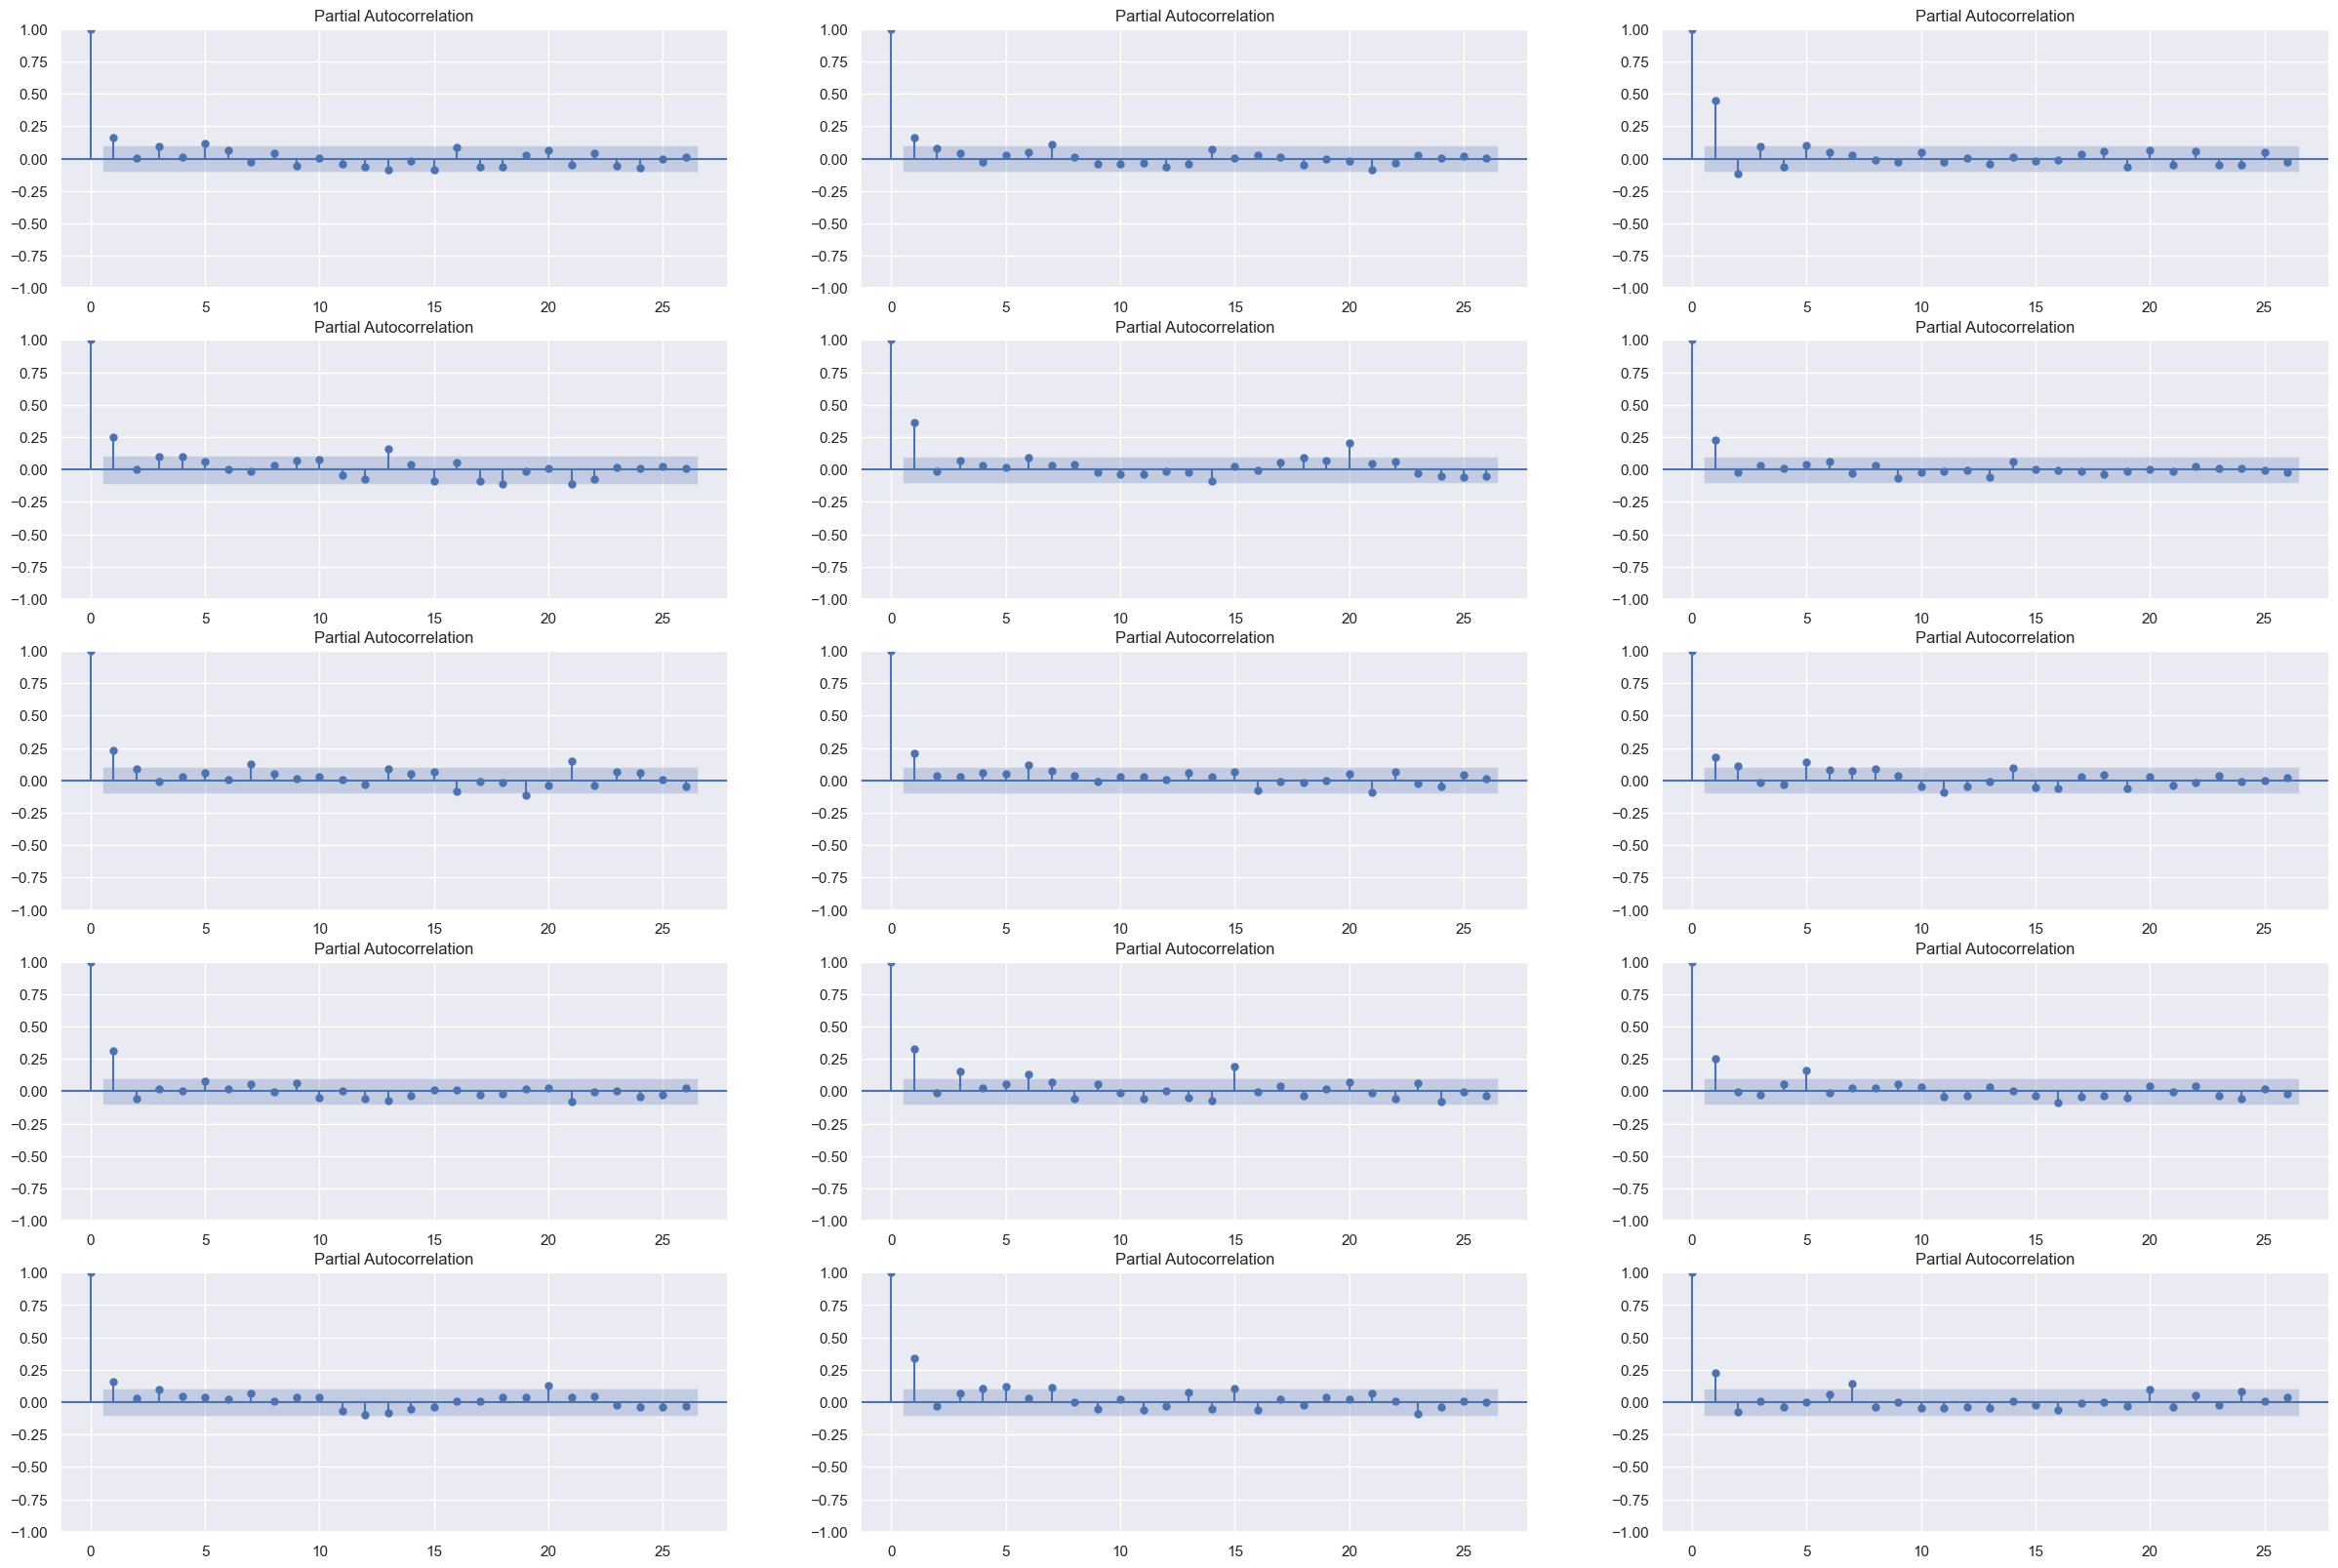

In [62]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(30, 20))
axs = axs.ravel()
i=0
ats = trade_deck["Ticker"].sample(n=15).values
for ticker in ats:
    #plot_acf(stock_data[ticker]["Intraday Vol"])
    groupby_obj = stock_data[ticker].groupby(pd.Grouper(freq='D'))
    y = groupby_obj.first()["Daily Vol"]
    y.fillna(y.mean(), inplace=True)
    plot_pacf(y, ax=axs[i])
    i+=1

The first lag is kind of significant which means yesterday's volatility is our best guess for the forecast of today's volatility for most of these volatilies. A way to model intraday volatility could be ARCH(1).

### Stock price partial autocorrelation

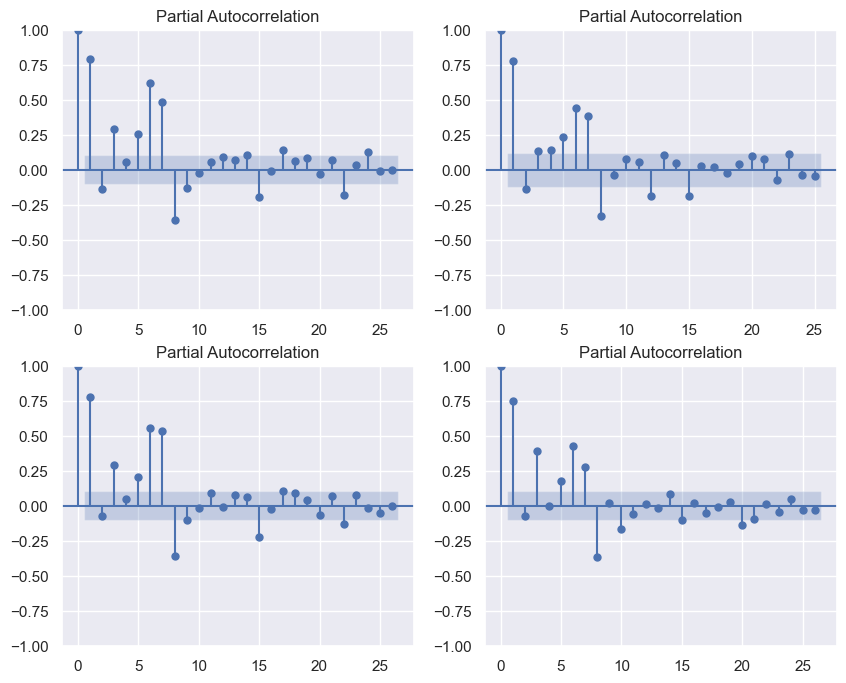

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ats = trade_deck["Ticker"].sample(n=4).values
row, col = 0, 0
for ticker in ats:
    #plot_acf(stock_data[ticker]["Intraday Vol"])
    groupby_obj = stock_data[ticker].groupby(pd.Grouper(freq='D'))
    y = groupby_obj["Adj Close"].median()
    y.fillna(y.mean(), inplace=True)
    plot_pacf(y, ax=axs[row, col])
    col = col+1
    if col == 2:
        row = row+1
        col=0

##### Stock price differenced autocorrelation

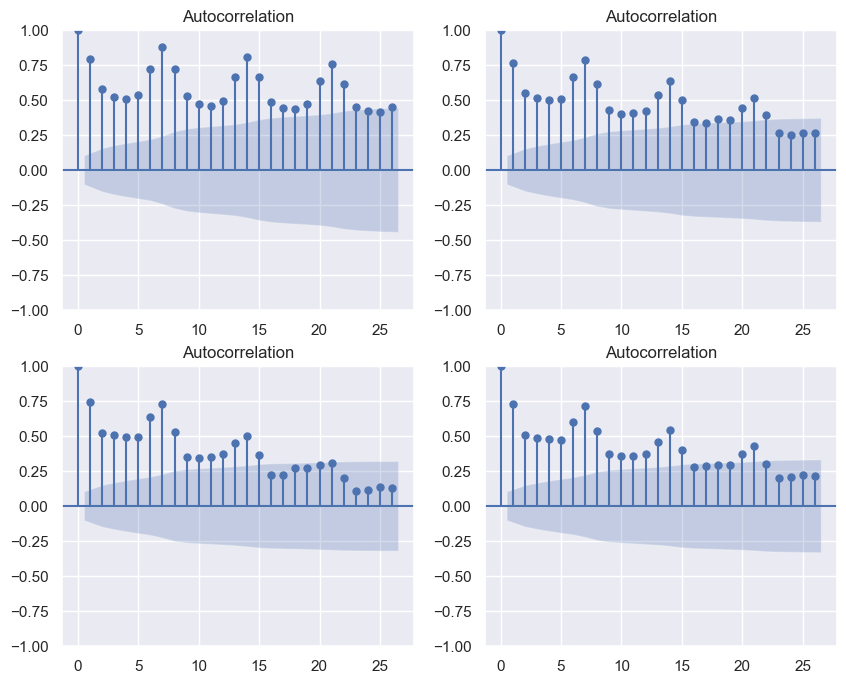

In [72]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ats = trade_deck["Ticker"].sample(n=4).values
row, col = 0, 0
for ticker in ats:
    #plot_acf(stock_data[ticker]["Intraday Vol"])
    groupby_obj = stock_data[ticker].groupby(pd.Grouper(freq='D'))
    y = groupby_obj["Adj Close"].median()
    y.fillna(y.mean(), inplace=True)
    y = y
    y.fillna(y.mean(), inplace=True)
    plot_acf(y, ax=axs[row, col])
    col = col+1
    if col == 2:
        row = row+1
        col=0

The daily stock prices seem to be difficult to model using time series.

### Frequency distribution of returns

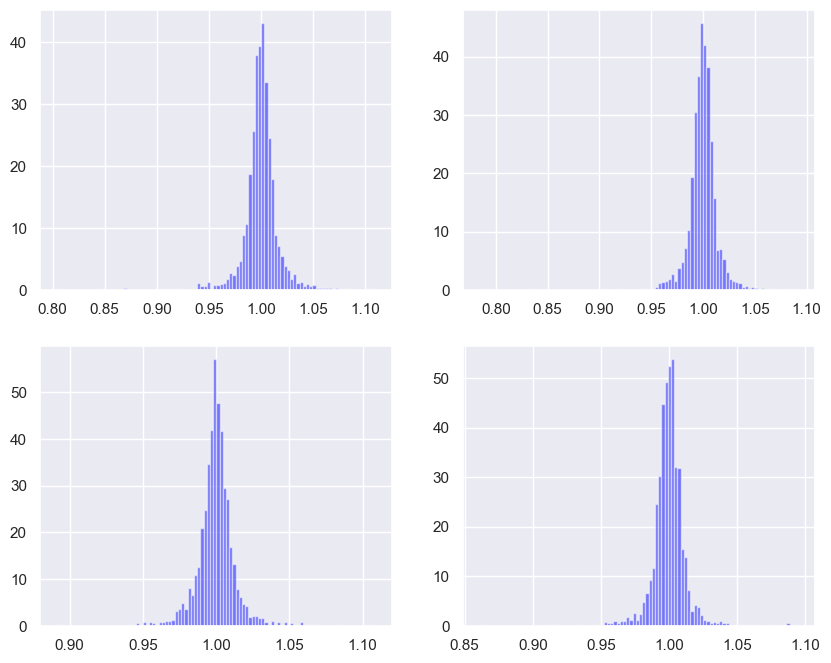

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
row, col = 0, 0
for ticker in ats:
    axs[row, col].hist(stock_data[ticker]["Returns"], bins=100, density=True, alpha=0.5, color='blue')
    col = col+1
    if col == 2:
        row = row+1
        col=0

The return series resemble a normal distribution to a good extent.

 # Trading strategy

### 1. We will use a pairs trading strategy for long short abitrage. For each high volatility stock we identify another one with highest correlation to its returns and assign them as a pair. If no such pair found we assign a pair randomly

In [295]:
pairs = []
for stock in trade_deck["Ticker"]:
    pair = ''
    prev_c = 0
    for stock2 in trade_deck["Ticker"]:
        c = stock_data[stock]["Returns"].corr(stock_data[stock2]["Returns"])
        if stock2 != stock and c > 0.5 and c > prev_c:
                prev_c = c
                pair = stock2
    pairs.append(pair)
    
trade_deck["Pair"] = pairs
trade_deck.loc[trade_deck["Pair"]=="", "Pair"] = trade_deck["Ticker"].sample(n=1).values[0]
trade_deck

,Ticker,Daily Vol,Pair
0,ETSY,0.015262,CDAY
1,CCL,0.015135,NCLH
2,ENPH,0.015000,SEDG
3,NCLH,0.014827,CCL
4,MRNA,0.014466,KMX
5,SEDG,0.014423,ENPH
6,CZR,0.013617,NCLH
7,GNRC,0.013405,ENPH
8,EPAM,0.013342,MPWR
9,WBD,0.013320,PARA


### 2. Since the 1st lag is the most significant we can use Exponential Moving Average (EMA) model to model volatilites with a weight of lets say 0.9

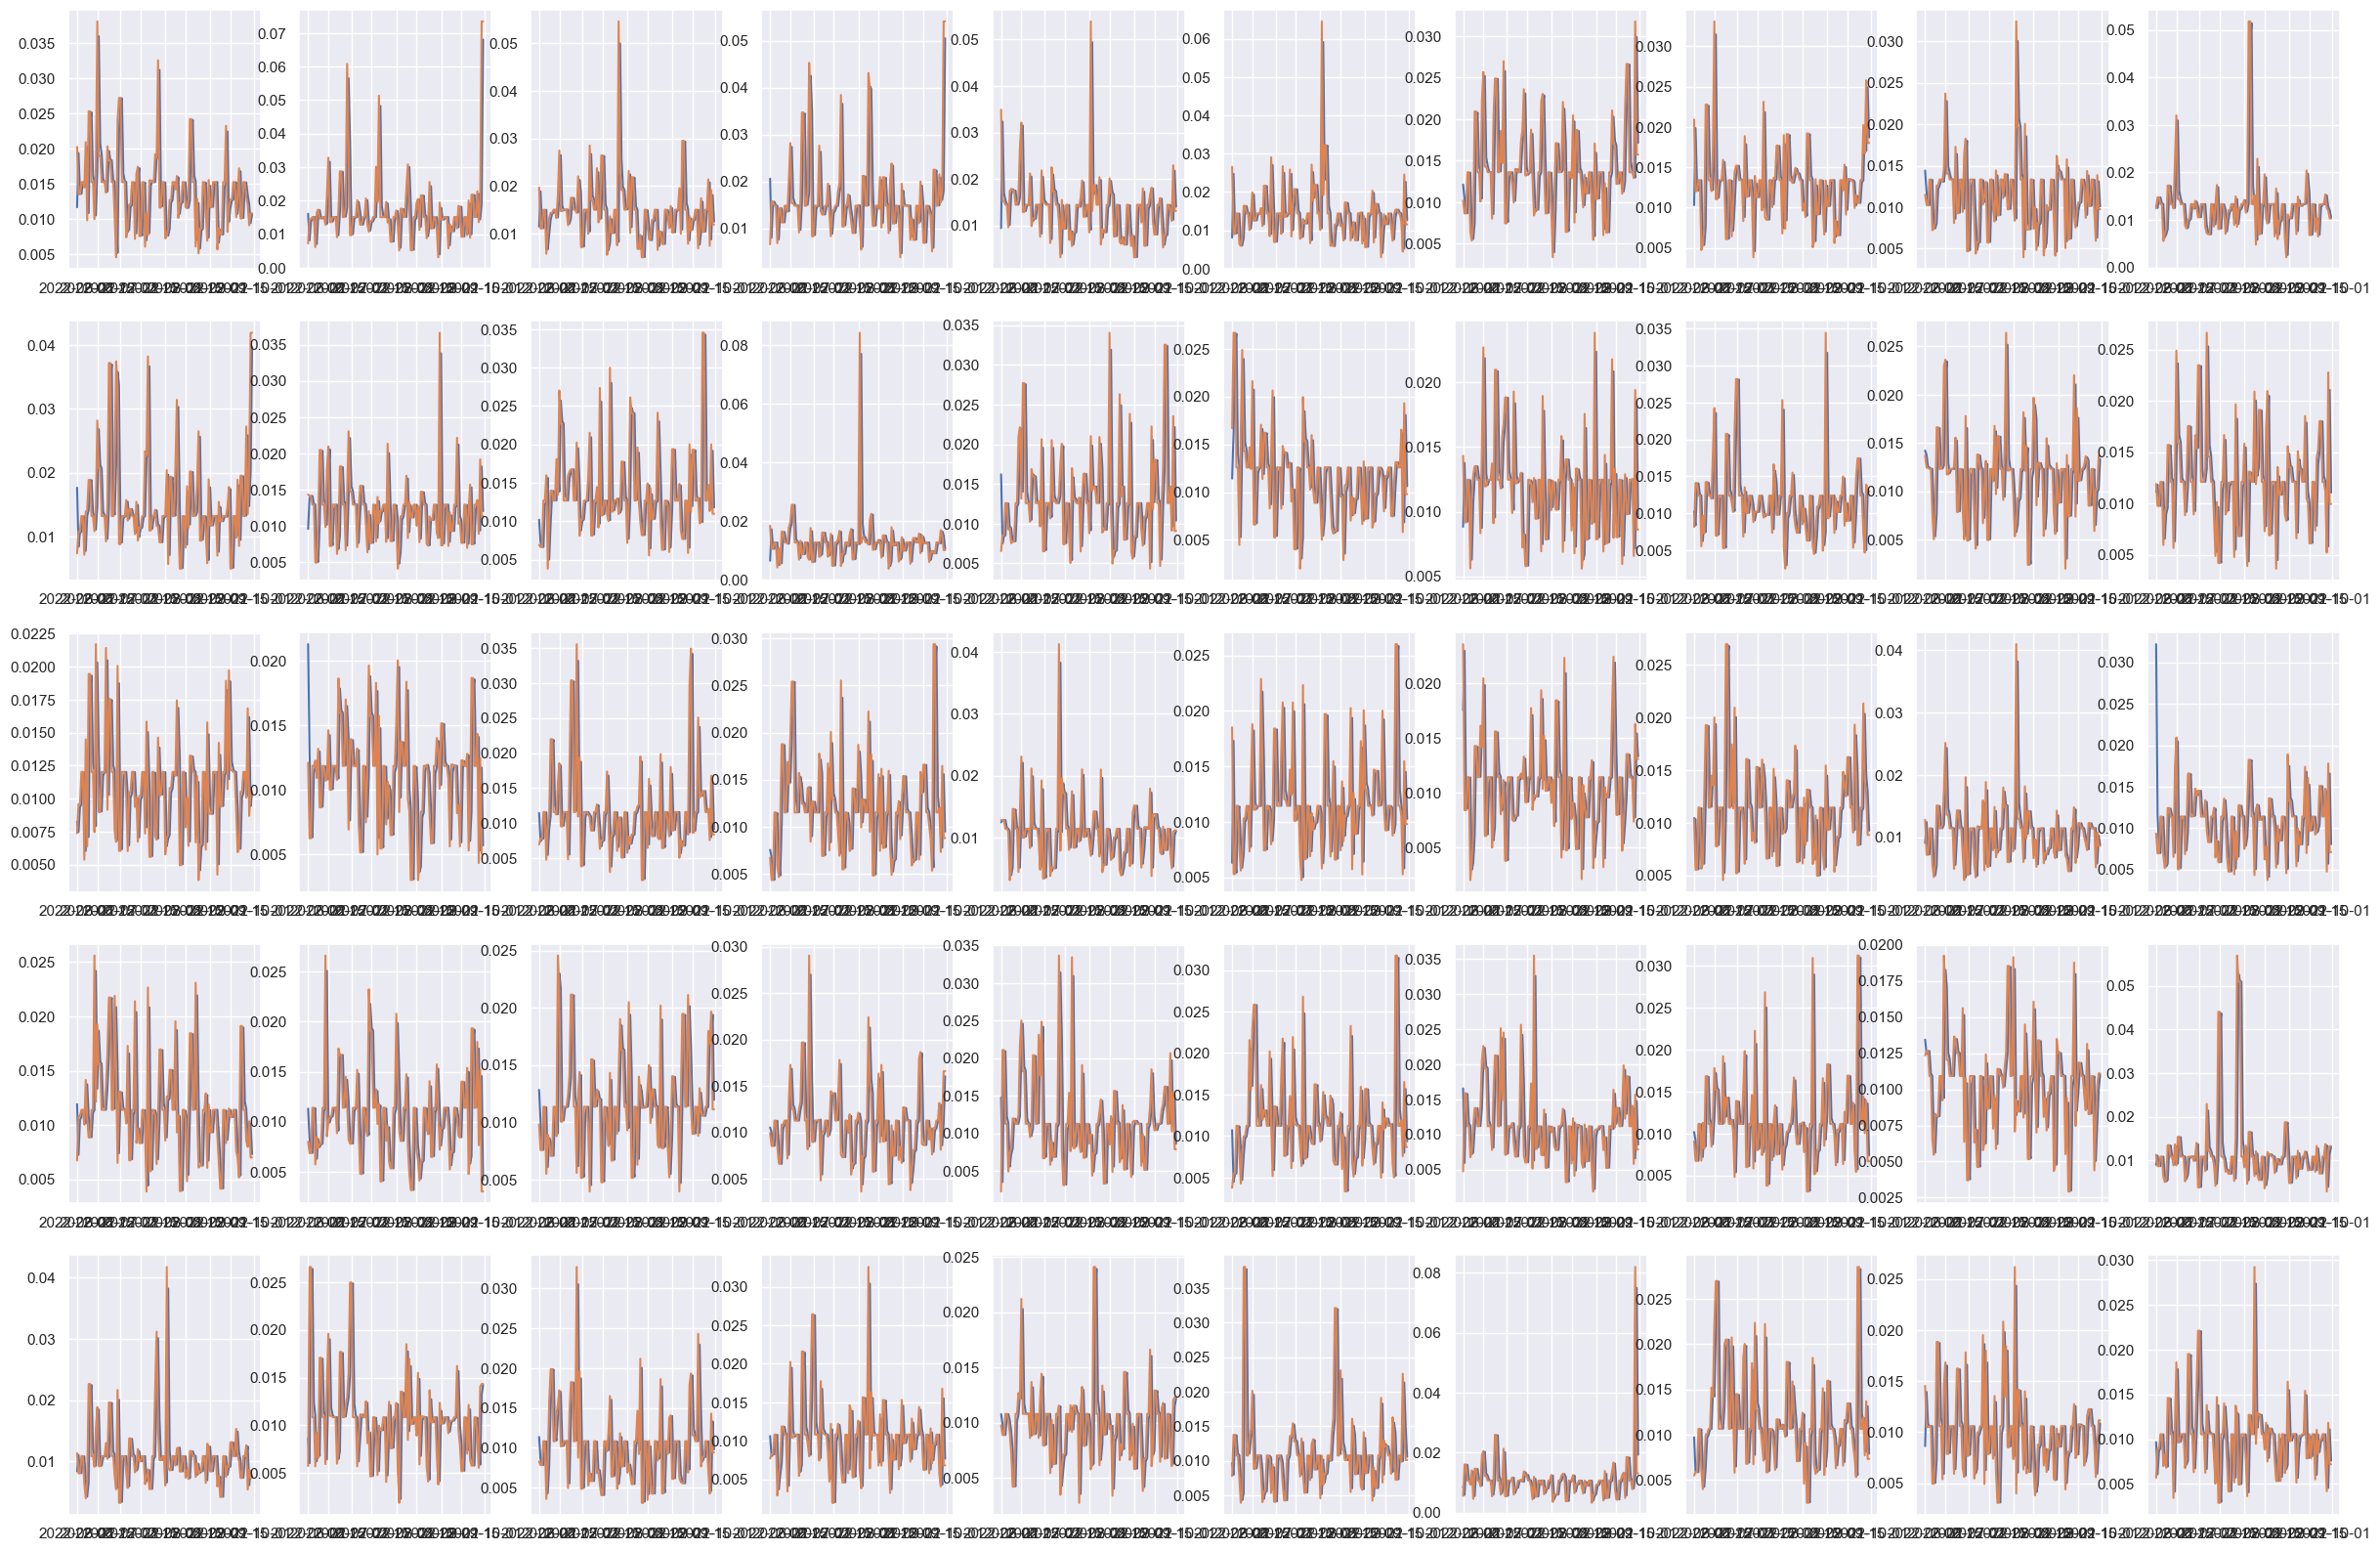

In [377]:
def ema_forecast(train_vol, alpha, horizon):
    ema = train_vol.ewm(alpha=alpha).mean()
    return ema.iloc[-1] * np.ones(horizon)

fig, axs = plt.subplots(5, 10, figsize=(30,20))
row, col = 0, 0
vol_fc = {}
for stock in trade_deck["Ticker"]:
    
    # For June to Sept
    train = stock_data[stock].resample('D').mean()
    train.fillna(train.mean(), inplace=True)
    test = train.loc['2022-06':'2022-09'].copy()
    test = test[["Daily Vol"]]

    alpha = 0.9
    forecasts = []

    for i in test.index:
        daily_vol = train.loc[(train.index < i)]["Daily Vol"]
        forecast = ema_forecast(daily_vol, alpha, 1)
        forecasts.append(forecast[0])

    test["Forecasts"] = forecasts
    vol_fc[stock] = test["Forecasts"]
    axs[row, col].plot(test["Forecasts"], label="Forecasts")
    axs[row, col].plot(test["Daily Vol"], label="Actual")
    col += 1
    if col == 10:
        row += 1
        col = 0

The forecasts and actual volatility plots are above for the 50 stocks in contention

# Signal Generation

### 3. We will use LSTM model to forecast prices based on which we will be creating positions
Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to learn and predict sequences of data where time series cannot efficiently model. Following is our trading algorithm

1. Identify undervalued and overvalued stocks based on trade volume, last close price, 20 day moving average using the LSTM model
2. If the forecasted price for the day is above 1x forecasted volatility we create a long position in the stock and a short position in its pair in ratio of their snp weights
3. If the forecasted price for the day is 1x forecasted volatility below we create a short position in the stock and a long position in its pair in ratio of their snp weights
4. We add the two positions to a position table and associate each other using a pair id.
5. The target price for the trade is the forecasted price. We check for this price every hour. We square off both the position when the price moves above (below for short) the forecast
6. We keep a stop loss of 3%. If our net pair trade value falls below 3% we square off the position and remove it from the position table
7. Calculate returns of portfolio each hour and sum them.
8. Calculate metrics - total trades, sharpe ratio, strategy capacity, win percentage, drawdown compared to SNP, information ratio, treynor ratio, profit-loss ratio, average win, turnover, annualized return, VaR, Expected Shortfall

In [374]:
# Preprocess the data
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Format the data
def format_df(df):
    # Select columns
    model_data = df[['Adj Close', 'Volume', 'Rolling Price']].values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    model_data = scaler.fit_transform(model_data)
    return model_data, scaler

def model_fit(df):
    # Set look_back window
    look_back = 1

    # Load your data
    # df = ...

    # Format and scale the data
    model_data, scaler = format_df(df)
    
    # Create dataset for the LSTM model
    X, Y = create_dataset(model_data, look_back)

    # Reshape the input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 3))

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X, Y, epochs=100, batch_size=32, verbose=0)
    return model

def predict(model, df):
    model_data, scaler = format_df(df)
    
    # Make a prediction for the next day
    last_data = np.array([model_data[-1]])  # Take the last row of the dataset
    next_day_prediction = model.predict(last_data.reshape(1, 1, -1), verbose=0)

    # Invert scaling to get the original scale
    next_day_prediction = scaler.inverse_transform(np.hstack([next_day_prediction, last_data[:, 1:]]))[:, 0]

    return next_day_prediction[0]

In [394]:
data = yf.download(tickers=trade_deck["Ticker"].tolist(), start="2018-01-01", end="2022-09-30", interval='1d')
data.fillna(data.mean(), inplace=True)

# Store each stock's data in a separate DataFrame
temp = {}
for ticker in trade_deck["Ticker"]:
    temp[ticker] = data.xs(ticker, level=1, axis=1)
data = temp

models = {}
window = 20
price_forecasts = []
for ticker in trade_deck["Ticker"]:
    df = data[ticker].copy()
    df["Rolling Price"] = df["Adj Close"].rolling(window=window).mean()
    df["Rolling Price"].fillna(df["Rolling Price"].mean(), inplace=True)
    df = df.drop(['Open', 'Close', 'High', 'Low'], axis=1)
    df["Market Cap"] = df["Adj Close"] * df["Volume"]
    
    # Training-Test split 
    split = df.index.get_loc(pd.to_datetime('2022-06-01 00:00:00-04:00'))
    
    # Price Forecasts
    forecasts = [0 for i in range(split)]
    model = model_fit(df[:split])
    models[ticker] = model
    for i in range(split, len(df)):
        forecasts.append(predict(model, df[:i]))    
    df["Price Forecasts"] = forecasts
    
    # Volatility Forecasts
    df = df.join(vol_fc[ticker].rename("Volatility Forecasts"))
    data[ticker] = df

[*********************100%***********************]  50 of 50 completed


In [395]:
# Backing up the data and models
backup_dfs = data
backup_models = models
position_table = pd.DataFrame(columns=["Id", "Creation Date", "Square Off Date" "PairId", "Ticker", "Target", "Price"])

In [393]:
test = stock_data[ticker].loc['2022-06':'2022-09'].copy()
forecast_df = data[ticker][["Price Forecasts", "Volatility Forecasts"]]
test = test.join(forecast_df.set_index(forecast_df.index.date), how='left')

,Adj Close,Volume,Rolling Price,Market Cap,Price Forecasts,Volatility Forecasts
Date,,,,,,
2018-01-02 00:00:00-05:00,49.642132,9819500,76.520914,4.874609e+08,0.000000,NaN
2018-01-03 00:00:00-05:00,50.521904,10898900,76.520914,5.506332e+08,0.000000,NaN
2018-01-04 00:00:00-05:00,50.812042,9462800,76.520914,4.808242e+08,0.000000,NaN
2018-01-05 00:00:00-05:00,51.102188,10902200,76.520914,5.571263e+08,0.000000,NaN
2018-01-08 00:00:00-05:00,52.337627,12658000,76.520914,6.624897e+08,0.000000,NaN
...,...,...,...,...,...,...
2022-09-23 00:00:00-04:00,83.888802,7384500,91.009244,6.194769e+08,85.103751,0.009757
2022-09-26 00:00:00-04:00,82.545227,7015800,90.220019,5.791208e+08,84.381800,0.010546
2022-09-27 00:00:00-04:00,83.749466,6220000,89.603468,5.209217e+08,83.109259,0.008003


## PS: REQUEST YOU FOR SOME TIME TO COMPLETE THIS PROJECT!! 

In [412]:
export = pd.concat(data.values(), axis=0)
export = export.reset_index().rename(columns={'index': 'Trade date'})
export['Ticker'] = list(data.keys()) * len(data['ETSY'])
export.to_csv('snp_volatility_trained_data_2022.csv', index=False)